#  Real Estate Housing Price Prediction

### Importing Libraries and creating a dataframe

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

df_1=pd.read_csv("Bengaluru_House_Data.csv")  #reading the dataset
df_1.head(10) #displays first 10 rows of the csv


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,NaN,1310,3.0,1.0,63.25
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00


In [2]:
df_1.shape  #shows the number of rows and columns of the dataset

(13320, 9)

In [3]:
#grouping beased upon area type 
df_1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

### dropping a few columns assuming them to non-influence the prediction model


In [4]:
#creating a new dataframe by dropping a few columns from df_1
df_2=df_1.drop(['area_type','availability', 'society', 'balcony'], axis='columns')
df_2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


###  Handling some NA values

In [5]:
#check the number of null values present in each column
df_2.isnull().sum() 


location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [6]:
med_bath=df_2['bath'].median() #calculates median of bath column

df_2['bath'].fillna(value=med_bath, inplace=True)  #NaN bath columns is filled with median values
df_2.isnull().sum()
df_2=df_2.dropna() #dropping the NA values
#df_2.isnull().sum()

## Feature Engineering

### Adding a new  'BHK' column

In [7]:
df_2['size'].unique()  #gives the unique strings in 'size' column 

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [8]:
#since there in non-uniformity in the Size column so a new column is created based upon just the first value of the string for each row in size column
df_2['BHK']=df_2['size'].apply(lambda x: int(x.split(' ')[0]))
df_2.head(10) #modified dataframe

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2
5,Whitefield,2 BHK,1170,2.0,38.00,2
6,Old Airport Road,4 BHK,2732,4.0,204.00,4
7,Rajaji Nagar,4 BHK,3300,4.0,600.00,4
8,Marathahalli,3 BHK,1310,3.0,63.25,3
9,Gandhi Bazar,6 Bedroom,1020,6.0,370.00,6


### Function to check if Float type 

In [9]:
#function to check if the given vlaue is float or not
def check_float(val):
    try:
        float(val)
    except:
        return False
    return True

df_2[~df_2['total_sqft'].apply(check_float)].head()  #using negate operation to find values that dont satisfy the float condition


,location,size,total_sqft,bath,price,BHK
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2


In [10]:
#converting the string with '-' into the average of the two values separated by the '-' token
def convert_sqft_to_num(val):
    tokens=val.split('-')
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(val)
    except:
        return None
df3=df_2.copy() #creating a copyof df_2 in new dataframe
df3['total_sqft']=df3['total_sqft'].apply(convert_sqft_to_num)
df3=df3[df3.total_sqft.notnull()]
df3.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [11]:
df3.loc[81]

location      Hennur Road
size            4 Bedroom
total_sqft         3203.5
bath                    2
price               224.5
BHK                     4
Name: 81, dtype: object

### Adding a new feature of Price per Square Feet

In [12]:
df3['price_per_sqft']=df3['price']*100000/df3['total_sqft'] #adding a new column in DF3
df3.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


### Removing extra spaces from location column and sorting location values and frequency in descending order

In [13]:
df3.location=df3.location.apply(lambda x:x.strip()) #remove leading or end spaces from loaction column

#new dataframe location_freq 
location_freq=df3.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_freq

location
Whitefield              538
Sarjapur  Road          397
Electronic City         304
Kanakpura Road          271
Thanisandra             236
                       ... 
Kumbhena Agrahara         1
Kudlu Village,            1
Konappana Agrahara        1
Kodanda Reddy Layout      1
1 Annasandrapalya         1
Name: location, Length: 1287, dtype: int64

## Dimensionality Reduction

####  Locations with frequencies <=10 are categorised as 'Other' locations. This is done to reduce the categories number which in turn results in lesser number of dummy columns while one hot encoding


In [14]:
#Storing unique location values with frequencies >=10
modified_location_freq=location_freq[location_freq<=10]
modified_location_freq

location
Ganga Nagar             10
Dairy Circle            10
Sadashiva Nagar         10
Naganathapura           10
Sector 1 HSR Layout     10
                        ..
Kumbhena Agrahara        1
Kudlu Village,           1
Konappana Agrahara       1
Kodanda Reddy Layout     1
1 Annasandrapalya        1
Name: location, Length: 1047, dtype: int64

In [15]:
#storing Location frequencies <5 in Other category
df3.location=df3.location.apply(lambda x:'other' if x in modified_location_freq else x)

#modified length of unique locations
len(df3.location.unique())

241

In [16]:
#print(len(df3.location.head()))
df3.head(15)


,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


## Outlier Removal

### Creating a new dataframe with total_sqft/bhk values >=250

In [17]:
#finding anomalies in the dataset by comparing total_sqft with BHK.
df3[(df3.total_sqft/df3.BHK<250)]


,location,size,total_sqft,bath,price,BHK,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000
...,...,...,...,...,...,...,...
13221,other,9 Bedroom,1178.0,9.0,75.0,9,6366.723260
13277,other,7 Bedroom,1400.0,7.0,218.0,7,15571.428571
13279,other,6 Bedroom,1200.0,5.0,130.0,6,10833.333333
13303,Vidyaranyapura,5 Bedroom,774.0,5.0,70.0,5,9043.927649


In [18]:
df4=df3[~(df3.total_sqft/df3.BHK<250)]  #new dataframe removing the anomalous values

df4.shape # shape of new dataframe

(12645, 7)

#### The above dataframe shows a number of abnormal values. For instance it shows 6BHK with area 1020 sqft. , 8BHK iwth 600 sqft. and so on. Therefore, these datapoints may effect the training and testing dataset and hence is removed 

## Removing outliers per location using Mean and Standard Deviation for each location


#### Some description of Price per Square Feet class

In [19]:
df3.price_per_sqft.describe()

count    1.325700e+04
mean     7.912825e+03
std      1.064976e+05
min      2.678298e+02
25%      4.271186e+03
50%      5.438596e+03
75%      7.313318e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [20]:
#creating a new function with dataframe as input and calculating mean and standard deviation for sub-dataframe

def remove_pps_outliers(df):
    df_outlier=pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_sqft)
        st=np.std(subdf.price_per_sqft)
#storing values with (mean+std) and (mean-std) in a separate dataframe and appending it in another dataframe
        reduced_df=subdf[(subdf.price_per_sqft >(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_outlier=pd.concat([df_outlier,reduced_df], ignore_index=True)
    return df_outlier

df5=remove_pps_outliers(df4)  #new dataframe after remvoing price_pps_outliers 
df5.shape

(10436, 7)

In [21]:
#function for Scatter-Plot taking dataframe and location as inputs
import matplotlib
def scatter_plot(df,location):
    bhk2=df[(df.location==location) & (df.BHK==2)]
    bhk3=df[(df.location==location) & (df.BHK==3)]
    matplotlib.rcParams['figure.figsize']= (15,10)
    plt.scatter(bhk2.total_sqft, bhk2.price_per_sqft, color='purple', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price_per_sqft, color='red', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price per Square Feet")
    plt.title(location)
    plt.legend()
    
# Purple Points= 2BHK
# Red Points= 3BHK

## Scatter Plot of 2BHK 7 3BHK properties for a couple of locations

### Location : Whitefield

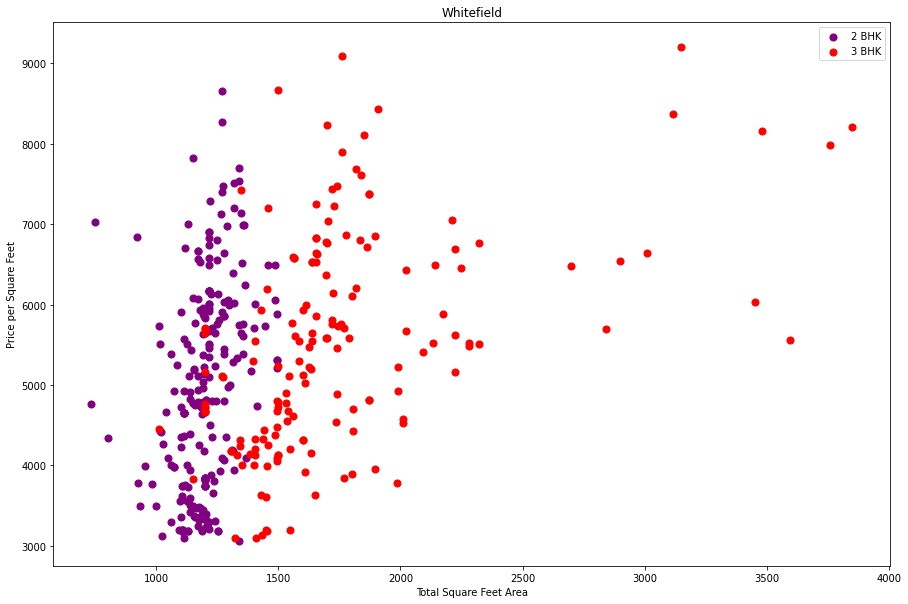

In [22]:
scatter_plot(df5,"Whitefield")    

### Location : Rajaji Nagar

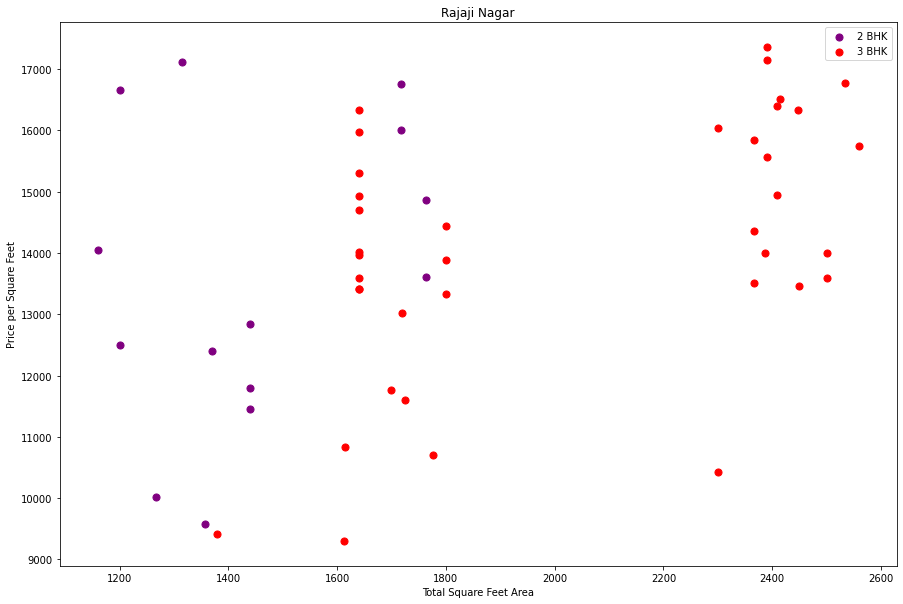

In [23]:
scatter_plot(df5,"Rajaji Nagar")    

### Location : Uttarahalli

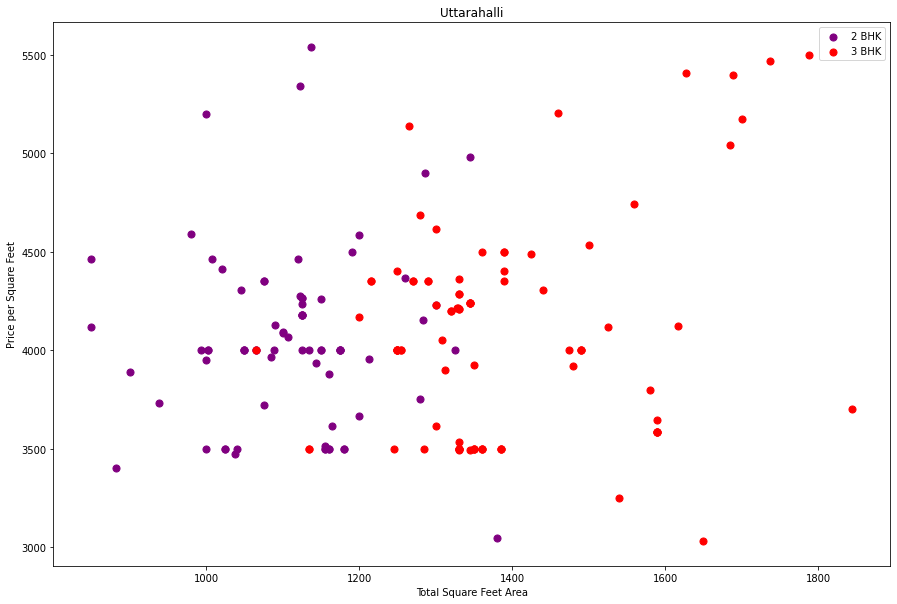

In [24]:
scatter_plot(df5,"Uttarahalli")    

###  Location : Hebbal

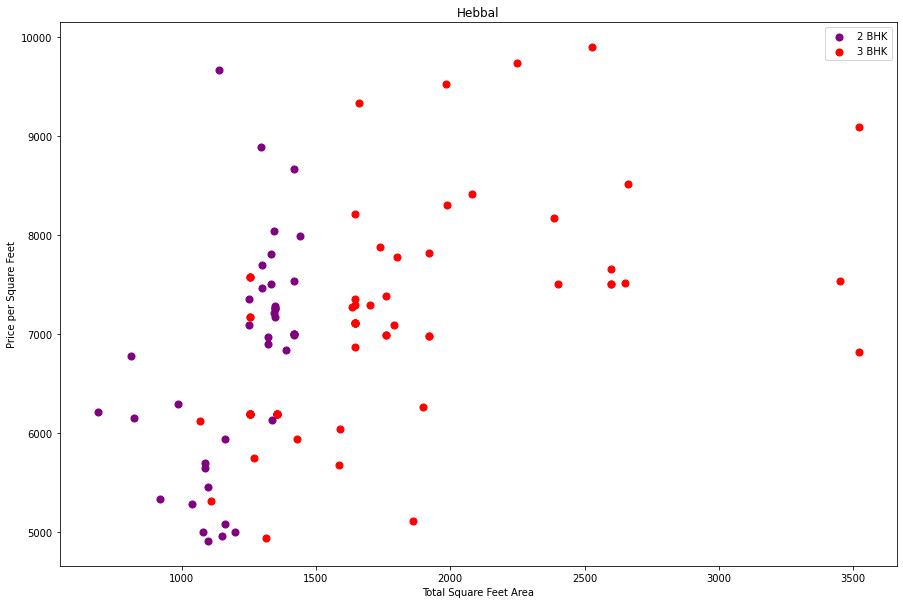

In [25]:
scatter_plot(df5,"Hebbal")

### Remove 2BHK apartments whose price_per_sqft is less tha mean price_per_sqft of 1BHK apartments


In [26]:
def remove_bhk_outliers(df):
    exclude_indices=np.array([])
    for location , location_df in df.groupby('location'):
        stats_bhk={}
# for every location a new dataframe is created based upon BHK and per bhk, mean, std and count is calculated
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats_bhk[bhk]={
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count':bhk_df.shape[0]
            }

        for bhk, bhk_df in location_df.groupby('BHK'):
            stats=stats_bhk.get(bhk-1)
# filtering out those values were Mean of 2BHK is less than Mean of 1BHK 
            if stats and stats['count']>5:
                exclude_indices=np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    
    return df.drop(exclude_indices,axis='index')
df6=remove_bhk_outliers(df5) # new dataframe df6 with  remove_bhk_outliers
df6.shape

(7442, 7)

### Plotting scatter plot again for 2BHK and 3BHK apartments after outliers removal


### Location : Whitefield

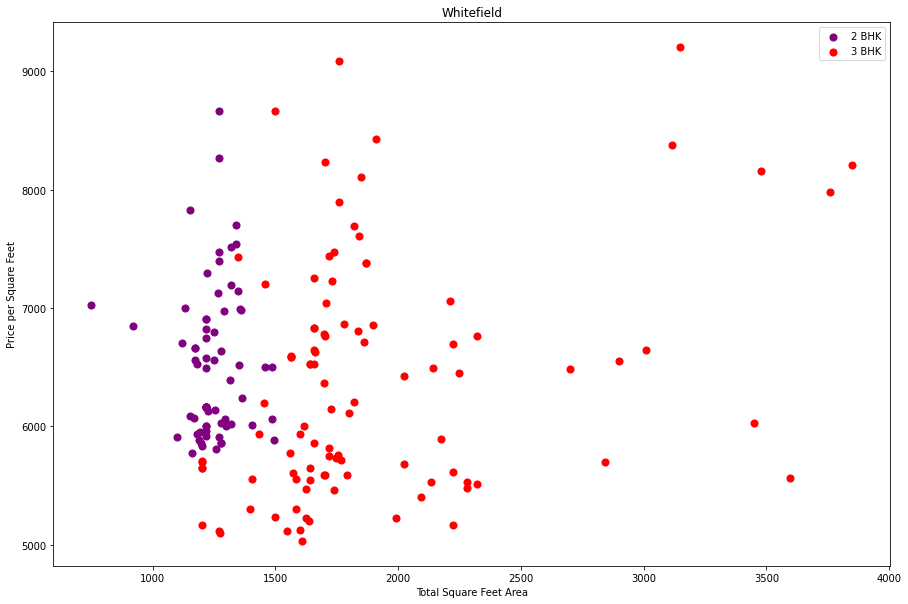

In [27]:
scatter_plot(df6,"Whitefield")

### Location: Rajaji Nagar

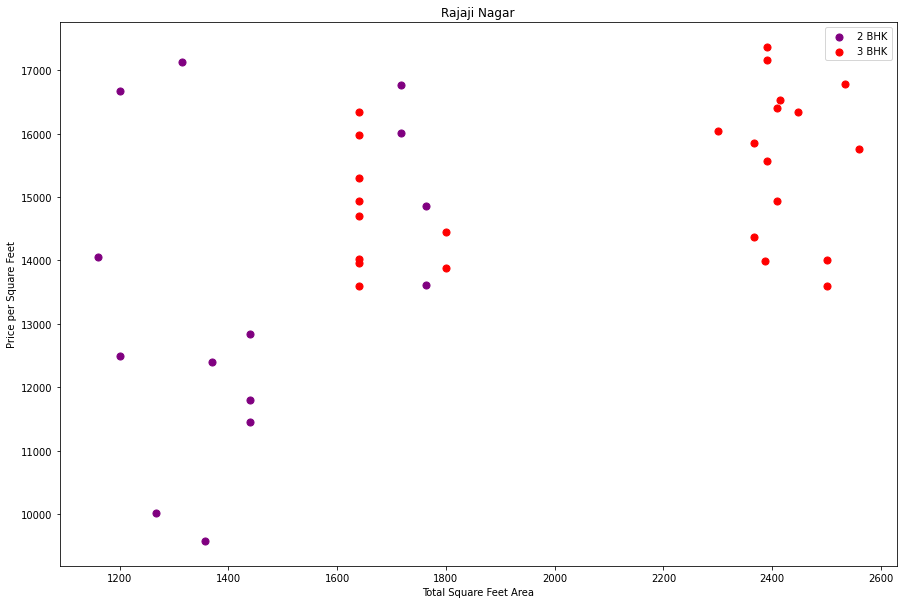

In [28]:
scatter_plot(df6, "Rajaji Nagar")

### Location : Uttarahalli

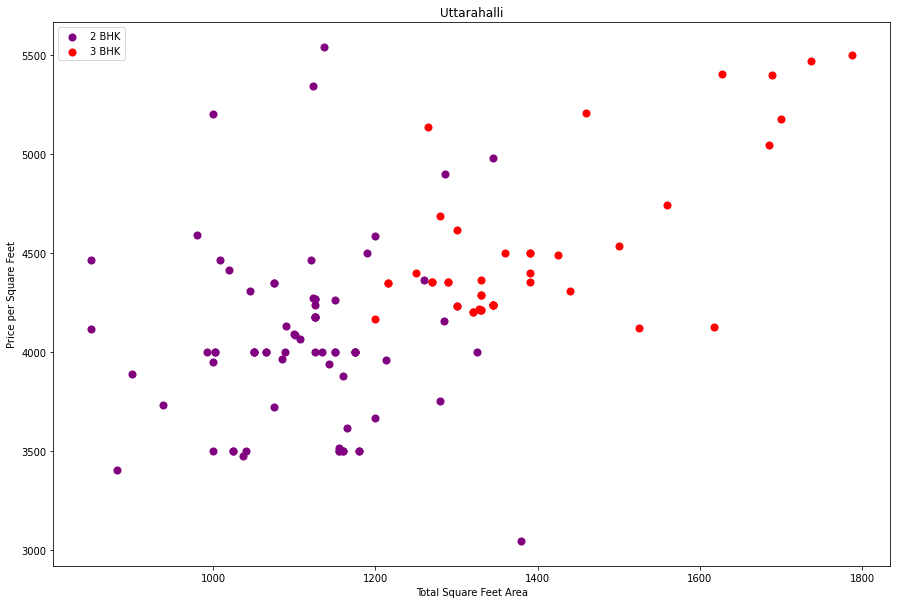

In [29]:
scatter_plot(df6, "Uttarahalli")

## Creating a Histogram

Text(0, 0.5, 'count')

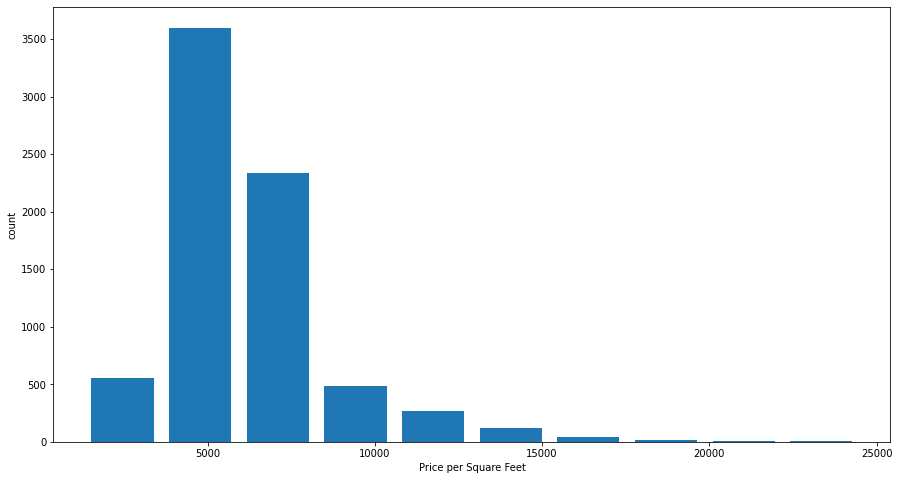

In [30]:
import matplotlib
matplotlib.rcParams["figure.figsize"]=(15,8)
plt.hist(df6.price_per_sqft, rwidth=0.8)
plt.xlabel("Price per Square Feet")
plt.ylabel("count")

## Outlier removal using Bathroom Feature

In [31]:
df6.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  9.,  7., 12., 27., 16., 13.])

### plotting a histogram with number of bathrooms and its count

Text(0, 0.5, 'Count')

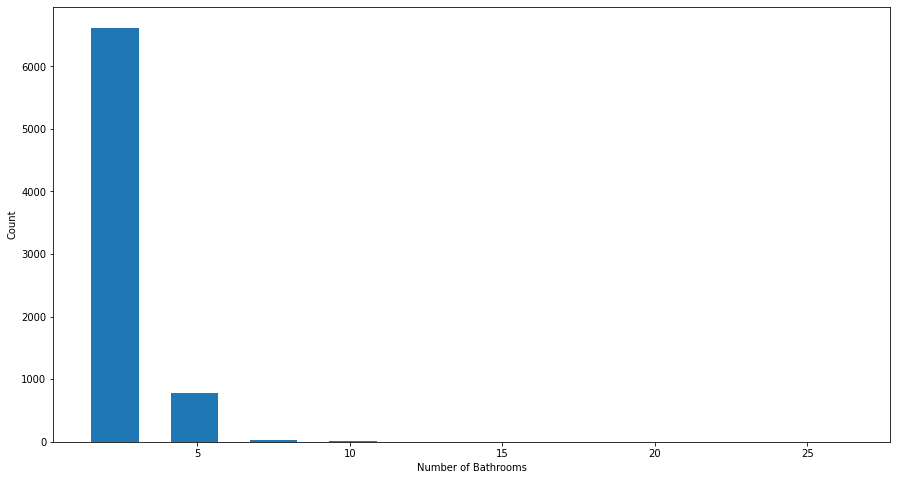

In [32]:
plt.hist(df6.bath, rwidth=0.6)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")

### Considering number of Bathrooms >= number of bedrooms+2 to be an abnormality so finding out those datapoints and removing them from the dataset

In [33]:
#DATAPOINTS WITH ABNOTMALITY
# following rows have bathrooms> BHK+2
df6[df6.bath>df6.BHK+2]

,location,size,total_sqft,bath,price,BHK,price_per_sqft
1540,Chamrajpet,6 Bedroom,1500.0,9.0,230.0,6,15333.333333
1675,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5351,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6852,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8571,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [34]:
#UPDATING THE DATASET
df7=df6[df6.bath<df6.BHK+2]
df7.shape #shape of updated dataset

(7361, 7)

In [35]:
#DROPPING SOME UNREQUIRED FEATURES LIKE 'size' SINCE BHK FEATURE IS CREATED
df7=df7.drop(['size', 'price_per_sqft'], axis='columns')
df7.head()

,location,total_sqft,bath,price,BHK
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [36]:
#Since Machine Learning models cannot interpret string as a categorical variable ,so coverting the string in Location column into numerical values using One-Hot Encoding

df_dummies=pd.get_dummies(df7.location)  #USING PANDAS DUMMIES METHOD
df_dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df8=pd.concat([df7, df_dummies.drop('other', axis='columns')], axis='columns')  #dropping the last column to avid Dummies trap and procedind using one less column
df8.head() #locations are now dummy encoded

,location,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#Dropping the location column
df8=df8.drop('location', axis='columns')

In [39]:
y_data=df8.price  #dependent variables
x_data=df8.drop('price', axis='columns')  #independent variables

### Dividing the dataframe into training and testing dataset 

In [40]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split( x_data, y_data, test_size=0.25, random_state=10)

### Model : Linear Regression()

In [41]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(x_train,y_train) #Fitting the Model
lin_reg.score(x_test, y_test) #checking score

0.8066745446473305

### Model : Cross Validation() 

In [42]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=1)

cross_val_score(LinearRegression(), x_data, y_data, cv=cv)

array([0.86222971, 0.79698147, 0.87218875, 0.8071695 , 0.86427133])

#### For 5 folds, we have  4 iterations where score is above  80% while for the other 1 we have score  close to 80% 

## Finding the best fit model using GridSearchCV

#### Running the training dataset on different models and parameters

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

#using Grid Search CV finding out the best model among Linear Regression, Lasso Regression and Decision Tree Model
def find_best_model_using_gridsearchcv(x_data, y_data):
    algos={
        'linear_regression':{
            'model': LinearRegression(),
            'params':{
                'normalize':[True, False]
            }
        },
        
        'lasso':{
            'model':Lasso(),
            'params':{
                'alpha' :[1,2],
                'selection':['random', 'cyclic']
            }
        },
        
        'decision_tree':{
            'model': DecisionTreeRegressor(),
            'params':{
                'criterion' :['mse','friedman_mse'],
                'splitter':['best', 'random']
            }
        }
    }
    
    scores=[]
    #Using Cross-Validation Shuffle split to randomly shuffle the sample to get better result 
    cv=ShuffleSplit(n_splits=5, test_size=0.30, random_state=0)
    for algo_name, config in algos.items():
        gs=GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x_data, y_data)
        scores.append({
            'model':algo_name,  #best algorithm
            'best_score': gs.best_score_,   #best score
            'best_params' : gs.best_params_   #best parameters
        })
        
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

find_best_model_using_gridsearchcv(x_data, y_data)

,model,best_score,best_params
0,linear_regression,0.810650,{'normalize': False}
1,lasso,0.687073,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.685823,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


#### From the above results, Linear Regression gives the best score followed by Lasso and Decision Tree

## Testing Model on some properties

In [44]:
def price_prediction(location,sqft,bath,BHK):
    index_location=np.where(x_data.columns==location)[0][0] #gives the index of required location
    
    x_var=np.zeros(len(x_data.columns))
    x_var[0]=sqft
    x_var[1]=bath
    x_var[2]=BHK
    if index_location >=0:
        x_var[index_location]=1
    
    return lin_reg.predict([x_var])[0]

In [45]:
price_prediction ('1st Phase JP Nagar', 1000,2,2)

93.02020706605381

In [46]:
price_prediction ('1st Phase JP Nagar', 1000,3,2)

95.60191682981089

In [47]:
price_prediction ('Indira Nagar', 1000,2,2)

168.3205424083024

In [48]:
price_prediction ('Indira Nagar', 1000,3,3)

168.3313268889226

In [49]:
#exporting the model to pickle file
import pickle
with open ('bangalore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lin_reg,f)

In [135]:
#exporting columns information into json file
import json
columns={
    'data_columns' : [col.lower() for col in x_data.columns]
}
with open (" columns.json", "w") as f:
    f.write(json.dumps(columns))